In [41]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *


In [42]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [43]:
species = 'mouse'

ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]
human_mouse_sect_cons = '../fig5/human_mouse_sect_cons.tsv'


ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

ver = 'vM25_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
min_perc = 80

sig_threshes = [0.05, 0.01, 0.001]
sig_annots = ['*', '**', '***']

## Mouse

In [44]:
min_samples = 10

In [45]:
ca = cerberus.read(cerberus_h5)

In [46]:
# limit to protein coding
g_df, _, _ = get_gtf_info(ver=ver, how='gene', add_stable_gid=True)
g_df = g_df[['gid_stable', 'biotype_category']]
g_df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
pc_gids = g_df.loc[g_df.biotype_category=='protein_coding'].gid.tolist()
print(len(ca.triplets.index))
ca.triplets = ca.triplets.loc[ca.triplets.gid.isin(pc_gids)]
print(len(ca.triplets.index))

1092960
924815


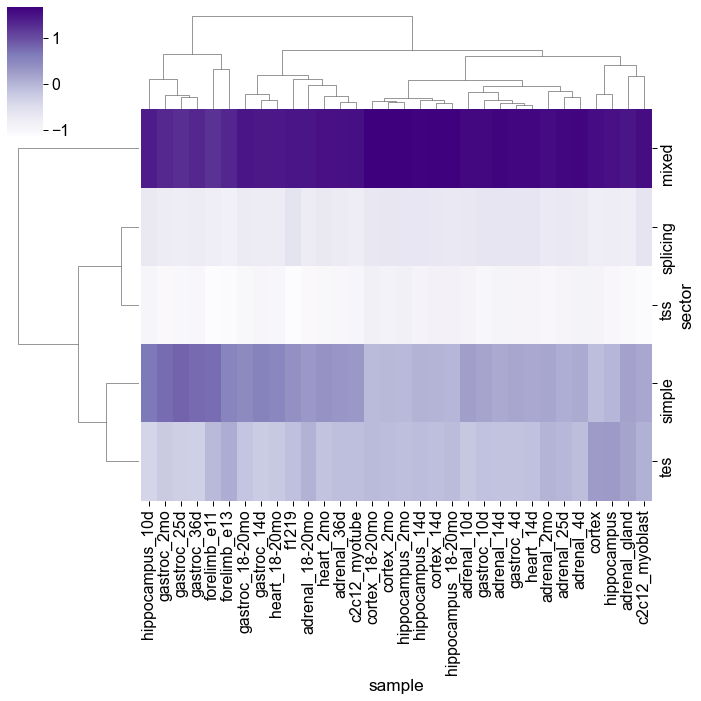

In [47]:
# heatmap of n genes in each sector across samples
df = ca.triplets.copy(deep=True)
df = df.loc[df.source=='sample_det']
df = df[['sample', 'sector', 'gid']].groupby(['sample', 'sector']).nunique().reset_index().rename({'gid':'n_genes'}, axis=1)
df = df.pivot(columns='sample', index='sector', values='n_genes')
df.head()
sns.clustermap(df, cmap='Purples', xticklabels=True, z_score=1)

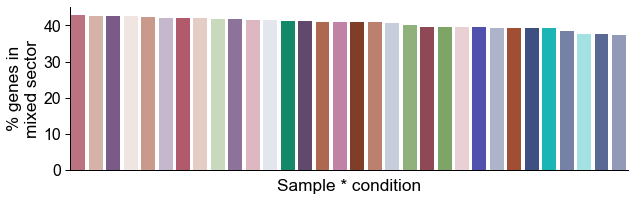

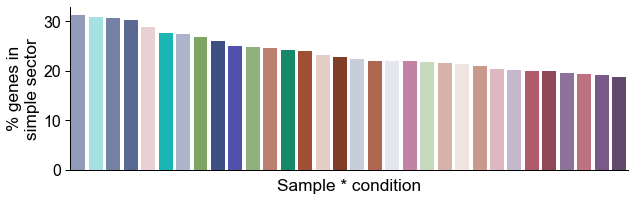

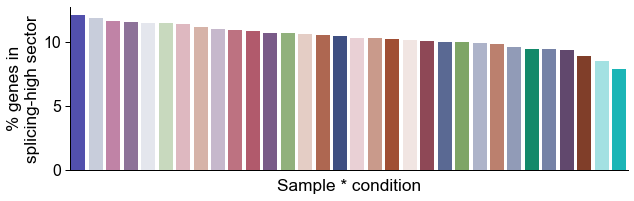

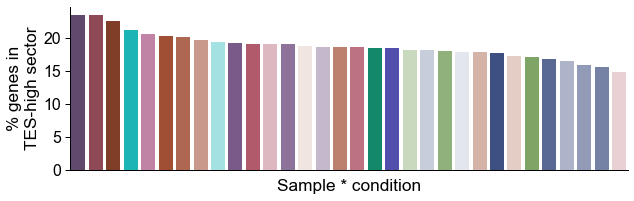

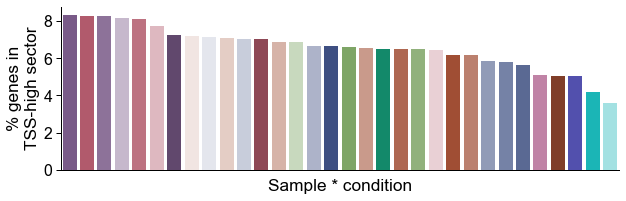

In [48]:
# ranked bar plot of % genes in each sector by sample
df = ca.triplets.copy(deep=True)
df = df.loc[df.source=='sample_det']
df = df[['sample', 'sector', 'gid']].groupby(['sample', 'sector']).nunique().reset_index().rename({'gid':'n_genes'}, axis=1)
temp = df[['sample', 'n_genes']].groupby('sample').sum().reset_index().rename({'n_genes':'n_tot_genes'}, axis=1)
df = df.merge(temp, how='left', on='sample')
df['perc'] = (df['n_genes']/df['n_tot_genes'])*100

meta_df = pd.read_csv(lib_meta, sep='\t')
meta_df = meta_df[['sample', 'sample_display', 'sample_color_hex_code']].drop_duplicates()
c_dict = dict([(s, c) for s,c in zip(meta_df.sample_display.tolist(),
                                     meta_df.sample_color_hex_code.tolist())])
df = df.merge(meta_df, how='left', on='sample')
for s in df.sector.unique().tolist():
    
    sns.set_context('paper', font_scale=1.8)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    plt.figure(figsize=(10,3))
    
    temp = df.loc[df.sector==s]
    temp = temp.sort_values(by='perc', ascending=False)
    ax = sns.barplot(temp, y='perc', x='sample_display', palette=c_dict)
    if s in ['tss', 'tes']:
        s_label = s.upper()
    else:
        s_label = s
    if s in ['tss', 'tes', 'splicing']:
        s_label+='-high'
    ylabel = f'% genes in\n{s_label} sector'
    xlabel = 'Sample * condition'
    ax.set(ylabel=ylabel, xlabel=xlabel)
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    fname = f'figures/{s}_perc_genes_per_sect_sample.pdf'
    plt.savefig
    plt.show()
    

,sample,sector,n_genes,n_tot_genes,perc,sample_display,sample_color_hex_code
0,adrenal_10d,mixed,5769,13766,41.907598,Adrenal gland PND10,#e9cac0
1,adrenal_10d,simple,3189,13766,23.165771,Adrenal gland PND10,#e9cac0
2,adrenal_10d,splicing,1463,13766,10.627633,Adrenal gland PND10,#e9cac0
3,adrenal_10d,tes,2366,13766,17.187273,Adrenal gland PND10,#e9cac0
4,adrenal_10d,tss,979,13766,7.111725,Adrenal gland PND10,#e9cac0


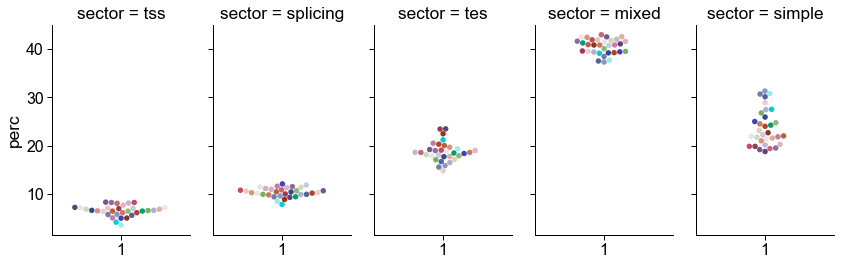

In [49]:
# catplot
df = ca.triplets.copy(deep=True)
df = df.loc[df.source=='sample_det']
df = df[['sample', 'sector', 'gid']].groupby(['sample', 'sector']).nunique().reset_index().rename({'gid':'n_genes'}, axis=1)
temp = df[['sample', 'n_genes']].groupby('sample').sum().reset_index().rename({'n_genes':'n_tot_genes'}, axis=1)
df = df.merge(temp, how='left', on='sample')
df['perc'] = (df['n_genes']/df['n_tot_genes'])*100
c_dict, order = get_biosample_colors(species='mouse')
c_dict_2, order_2 = get_sector_colors()
g = sns.catplot(data=df, x=1, y='perc', kind='swarm',
            height=4, aspect=.6, hue='sample', s=30,
            col_order=order_2,
            palette=c_dict, col='sector', legend=False)
meta_df = pd.read_csv(lib_meta, sep='\t')
meta_df = meta_df[['sample', 'sample_display', 'sample_color_hex_code']].drop_duplicates()
df = df.merge(meta_df, how='left', on='sample')
df.to_csv('mouse_sample_sector_perc_genes_for_sam.tsv', sep='\t', index=False)
df.head()


## Mode comparisons

In [50]:
# limit to sample_det
df = ca.triplets.copy(deep=True)

df = ca.triplets.copy(deep=True)

# remove genes that are simply globally
gids = df.loc[(df.source=='obs_det')&(df.sector=='simple'), 'gid'].tolist()
print(len(df.index))
df = df.loc[~df.gid.isin(gids)]
print(len(df.index))
            

df = df.loc[df.source=='sample_det']

# for each gene, compute the mode sector
temp = df[['gid', 'sector']].groupby('gid').agg(lambda x: st.mode(x)[0]).reset_index().rename({'sector':'mode_sector'}, axis=1)
df = df.merge(temp, how='left', on='gid')

# which samples have the same sector as mode?
df['same_as_mode'] = df.sector==df.mode_sector
df.head()

# what % of samples / gene have the same sector?
temp = df[['gid', 'same_as_mode', 'mode_sector', 'sample']].groupby(['gid', 'same_as_mode', 'mode_sector']).count().reset_index().rename({'sample':'n_samples'}, axis=1)
temp2 = df[['gid', 'sample']].groupby('gid').count().reset_index().rename({'sample':'n_tot_samples'}, axis=1)
temp = temp.merge(temp2, how='left', on='gid')

# remove things that are only expressed in a few samples
temp = temp.loc[temp.n_tot_samples >= min_samples]
temp['perc'] = (temp.n_samples/temp.n_tot_samples)*100

# # remove things that are all simple
# temp = temp.loc[temp.mode_sector != 'simple']

# now get the 2nd mode
temp2 = df.loc[df.same_as_mode==False]
temp2 = temp2[['gid', 'sector']].groupby('gid').agg(lambda x: st.mode(x)[0]).reset_index().rename({'sector':'mode_sector_2'}, axis=1)
temp = temp.merge(temp2, 
                  on='gid',
                  how='left')

# add biotype info
g_df, _, _ = get_gtf_info(ver=ver, how='gene', add_stable_gid=True)
temp = temp.merge(g_df[['gid_stable',
                      'gname',
                      'biotype_category']].rename({'gid_stable':'gid'}, axis=1),
                      how='left', on='gid')

924815
858987


In [51]:
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category
0,ENSMUSG00000000028,False,mixed,12,32,37.500000,tss,Cdc45,protein_coding
1,ENSMUSG00000000028,True,mixed,20,32,62.500000,tss,Cdc45,protein_coding
2,ENSMUSG00000000056,True,mixed,32,32,100.000000,NaN,Narf,protein_coding
3,ENSMUSG00000000058,False,mixed,15,31,48.387097,simple,Cav2,protein_coding
4,ENSMUSG00000000058,True,mixed,16,31,51.612903,simple,Cav2,protein_coding


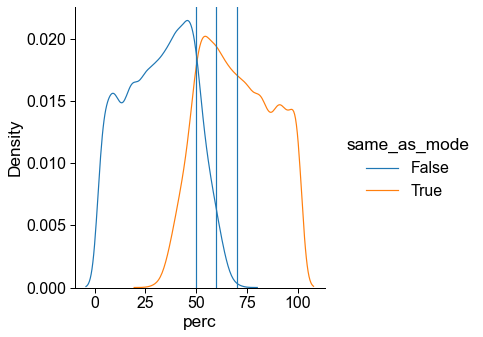

In [52]:
ax = sns.displot(temp, 
                 x='perc',
                 hue='same_as_mode',
                 common_norm=False,
                 kind='kde')
plt.axvline(x=50)
plt.axvline(x=60)
plt.axvline(x=70)

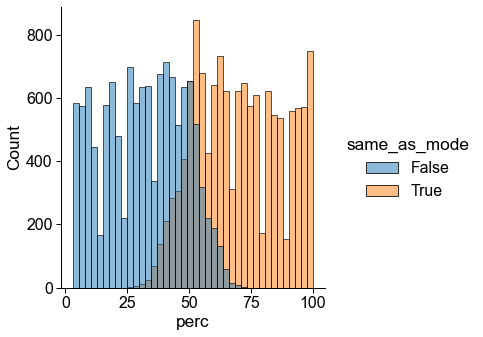

In [53]:
ax = sns.displot(temp, 
                 x='perc',
                 hue='same_as_mode')

In [54]:
temp2

,gid,mode_sector_2
0,ENSMUSG00000000028,tss
1,ENSMUSG00000000037,mixed
2,ENSMUSG00000000049,simple
3,ENSMUSG00000000058,simple
4,ENSMUSG00000000078,mixed
...,...,...
13385,ENSMUSG00000117809,tes
13386,ENSMUSG00000117942,tss
13387,ENSMUSG00000117975,mixed
13388,ENSMUSG00000118125,simple


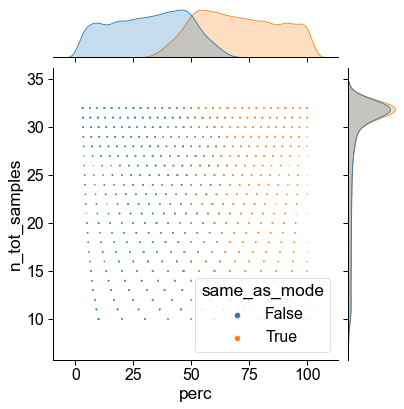

In [55]:
ax = sns.jointplot(temp,
                   x='perc',
                   y='n_tot_samples',
                   hue='same_as_mode',
                   joint_kws={'s':2,
                              'alpha':0.5})

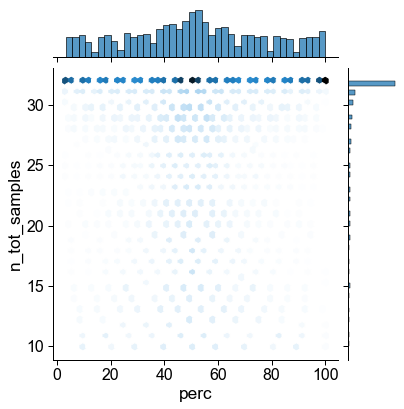

In [56]:
temp2 = temp.loc[temp.same_as_mode==True] 
ax = sns.jointplot(temp,
                   x='perc',
                   y='n_tot_samples',
                   kind='hex')

In [57]:
df.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,mode_sector,same_as_mode
0,sample_det,ENSMUSG00000000028,3.0,1.0,3.0,4.0,1.500000,0.545455,0.181818,0.272727,tss,Cdc45,gastroc_18-20mo,5.136519,mixed,False
1,sample_det,ENSMUSG00000000056,1.0,2.0,3.0,4.0,2.000000,0.200000,0.400000,0.400000,mixed,Narf,gastroc_18-20mo,287.693054,mixed,True
2,sample_det,ENSMUSG00000000058,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,Cav2,gastroc_18-20mo,33.597336,mixed,False
3,sample_det,ENSMUSG00000000078,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,Klf6,gastroc_18-20mo,17.854603,tes,False
4,sample_det,ENSMUSG00000000085,2.0,1.0,4.0,4.0,2.666667,0.352941,0.176471,0.470588,mixed,Scmh1,gastroc_18-20mo,22.045454,mixed,True


In [58]:
# look at max. number of isoforms
temp2 = df[['gid', 'n_iso']].groupby('gid').max().rename({'n_iso':'max_n_iso'}, axis=1).reset_index()
temp = temp.merge(temp2, 
                  how='left',
                  on='gid')
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso
0,ENSMUSG00000000028,False,mixed,12,32,37.500000,tss,Cdc45,protein_coding,6.0
1,ENSMUSG00000000028,True,mixed,20,32,62.500000,tss,Cdc45,protein_coding,6.0
2,ENSMUSG00000000056,True,mixed,32,32,100.000000,NaN,Narf,protein_coding,6.0
3,ENSMUSG00000000058,False,mixed,15,31,48.387097,simple,Cav2,protein_coding,3.0
4,ENSMUSG00000000058,True,mixed,16,31,51.612903,simple,Cav2,protein_coding,3.0


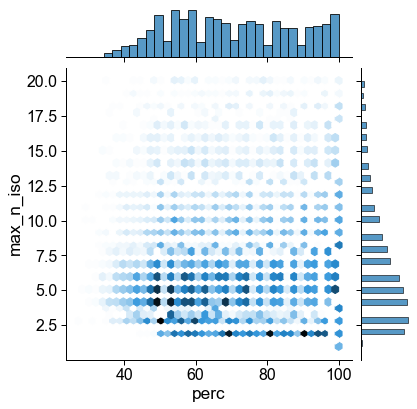

In [59]:
temp2 = temp.loc[temp.same_as_mode==True] 
temp2 = temp2.loc[temp2.max_n_iso<=20]
ax = sns.jointplot(temp2,
                   x='perc',
                   y='max_n_iso',
                   kind='hex')

In [60]:
temp.loc[temp.max_n_iso == 1]

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso
3662,ENSMUSG00000020193,True,simple,15,15,100.0,NaN,Zpbp,protein_coding,1.0
5776,ENSMUSG00000022521,True,simple,10,10,100.0,NaN,Crebbp,protein_coding,1.0
6475,ENSMUSG00000023964,True,simple,10,10,100.0,NaN,Calcr,protein_coding,1.0
7237,ENSMUSG00000024869,True,simple,12,12,100.0,NaN,Gm49405,protein_coding,1.0
8127,ENSMUSG00000026012,True,simple,12,12,100.0,NaN,Cd28,protein_coding,1.0
8293,ENSMUSG00000026196,True,simple,10,10,100.0,NaN,Bard1,protein_coding,1.0
10069,ENSMUSG00000028280,True,simple,11,11,100.0,NaN,Gabrr1,protein_coding,1.0
11252,ENSMUSG00000029553,True,simple,10,10,100.0,NaN,Tfec,protein_coding,1.0
11294,ENSMUSG00000029601,True,simple,11,11,100.0,NaN,Iqcd,protein_coding,1.0
11429,ENSMUSG00000029765,True,simple,12,12,100.0,NaN,Plxna4,protein_coding,1.0


## What sectors are the most sample-conserved vs. least?

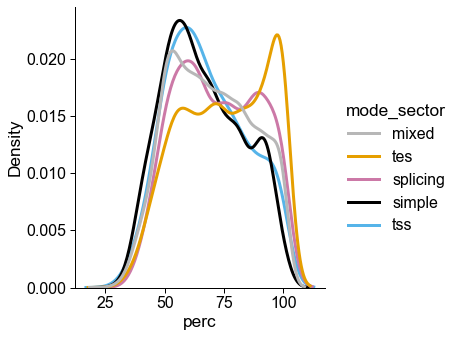

In [61]:
temp2 = temp.loc[temp.same_as_mode == True]
c_dict, order = get_sector_colors()
ax = sns.displot(temp2, 
                 x='perc',
                 hue='mode_sector',
                 palette=c_dict,
                 kind='kde',
                 linewidth=3,
                 common_norm=False)

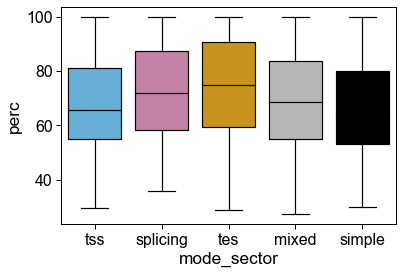

In [62]:
temp.head()
temp2 = temp.loc[temp.same_as_mode == True]
c_dict, order = get_sector_colors(cats=temp2.mode_sector.unique().tolist())
ax = sns.boxplot(temp2, 
                 y='perc',
                 x='mode_sector',
                order=order,
                palette=c_dict)

mixed vs. tes stat: 6488495.0, pval: 1.7285957553105942e-41
mixed vs. splicing stat: 3677402.5, pval: 1.536067411784058e-06
mixed vs. simple stat: 8048711.0, pval: 8.616412703666964e-14
mixed vs. tss stat: 2881868.5, pval: 0.01732445705048318
tes vs. splicing stat: 1800887.0, pval: 1.5902741167347263e-07
tes vs. simple stat: 3798133.5, pval: 9.881255720345112e-66
tes vs. tss stat: 1372527.0, pval: 1.5829124572263452e-24
splicing vs. simple stat: 1780201.0, pval: 4.122710994029875e-21
splicing vs. tss stat: 640191.0, pval: 9.481953199017617e-08
simple vs. tss stat: 964251.5, pval: 0.012192879123253812

Med. % samples same as mixed mode: 68.75
Med. % samples same as tes mode: 75.0
Med. % samples same as splicing mode: 71.875
Med. % samples same as simple mode: 64.28571428571429
Med. % samples same as tss mode: 65.625


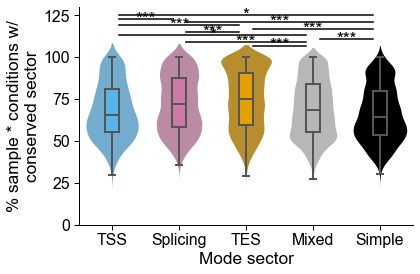

In [63]:
temp.head()
temp2 = temp.loc[temp.same_as_mode == True]
c_dict, order = get_sector_colors(cats=temp2.mode_sector.unique().tolist())
sns.set_context('paper', font_scale=1.8)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(6,4))
shade_dict, _ = get_shade_colors('#000000', ['dummy', False, True])
linecolor = shade_dict[False]
# ax = sns.boxplot(temp2, 
#                  y='perc',
#                  x='mode_sector',
#                 order=order,
#                 palette=c_dict,
#                 saturation=1,
#                 linewidth=2)

ax = sns.violinplot(temp2, y='perc',
                    x='mode_sector',
                    order=order,
                    palette=c_dict,
                    saturation=0.6,
                    inner=None, linewidth=0)

ax = sns.boxplot(temp2, y='perc',
                 x='mode_sector',
                 order=order,
                 palette=c_dict,
                 saturation=1,
                 width=0.2,
                 linewidth=2,
                 boxprops={'zorder': 2}, ax=ax)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
xlabel = 'Mode sector'
ylabel = '% sample * conditions w/\nconserved sector'

# stats test
pvals = {}
for i in temp2.mode_sector.unique():
    for j in temp2.mode_sector.unique():
        if i==j: continue
        
        key = tuple(sorted([i,j]))
        if key in pvals.keys(): continue
        x = temp2.loc[temp2.mode_sector==i, 'perc'].dropna().tolist()
        y = temp2.loc[temp2.mode_sector==j, 'perc'].dropna().tolist()
        stat, pval = st.mannwhitneyu(x,y)
        pvals[key] = pval
        print(f'{i} vs. {j} stat: {stat}, pval: {pval}')
    
print()
for i in temp2.mode_sector.unique():
    print(f"Med. % samples same as {i} mode: {temp2.loc[temp2.mode_sector==i, 'perc'].median()}")
    
box_patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax.artists
    box_patches = ax.artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):

    # Set the linecolor on the patch to the facecolor, and set the facecolor to None
    patch.set_edgecolor(linecolor)

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(linecolor)
        line.set_mfc(linecolor)  # facecolor of fliers
        line.set_mec(linecolor)  # edgecolor of fliers
    
# add pvals to boxplto
pvals
tick_dict = dict([(s.get_text(),c) for c, s in zip(ax.get_xticks(),ax.get_xticklabels())])
i = 0
for key, pval in pvals.items():
    # print(i)
    i+=1
    if pval <= max(sig_threshes):
        for annot, thresh in zip(sig_annots, sig_threshes):
            if pval <= thresh:
                sig_annot = annot
    else:
        continue
    
    s1 = key[0]
    s2 = key[1]
    x1 = min(tick_dict[s1], tick_dict[s2])
    x2 = max(tick_dict[s2], tick_dict[s1])
    diff = abs(x1-x2)
    y = 105 + 2*i
    h = 0.05
    color = 'k'
    # print(s1)
    # print(s2)
    # print(diff)
    # print([x1+0.1, x2-0.1])
    # print()

    plt.plot([x1+0.1, x2-0.1], [y, y], lw=1.5, c=color)
    plt.text((x1+x2)*.5, y, sig_annot, ha='center', va='center', color=color)
    
    # if i == 4: break
    

    
xticklabels = [s.get_text().upper() if s.get_text() in ['tss', 'tes'] else s.get_text().capitalize() for s in ax.get_xticklabels()]
_ = ax.set(ylabel=ylabel, xlabel=xlabel, xticklabels=xticklabels, ylim=(0, 130))

fname = 'figures/mouse_sample_sector_conservation_violin.pdf'
plt.savefig(fname, dpi=500)

In [64]:
temp.loc[temp.gname=='Bdnf']

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso
20456,ENSMUSG00000048482,False,tes,18,28,64.285714,tss,Bdnf,protein_coding,22.0
20457,ENSMUSG00000048482,True,tes,10,28,35.714286,tss,Bdnf,protein_coding,22.0


## What % of these genes have "conserved" behavior across samples?

In [65]:
n = len(temp.gid.unique().tolist())
n_num = len(temp.loc[(temp.same_as_mode==True)&(temp.perc>=min_perc)].index)
print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) genes have >={min_perc}% of expressed samples in the same sector as the mode')

32.96% (4380/13288) genes have >=80% of expressed samples in the same sector as the mode


## What % of these genes have "conserved" behavior across samples; by mode sector

In [66]:
temp['n_tot_genes'] = len(temp.gid.unique().tolist())
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso,n_tot_genes
0,ENSMUSG00000000028,False,mixed,12,32,37.500000,tss,Cdc45,protein_coding,6.0,13288
1,ENSMUSG00000000028,True,mixed,20,32,62.500000,tss,Cdc45,protein_coding,6.0,13288
2,ENSMUSG00000000056,True,mixed,32,32,100.000000,NaN,Narf,protein_coding,6.0,13288
3,ENSMUSG00000000058,False,mixed,15,31,48.387097,simple,Cav2,protein_coding,3.0,13288
4,ENSMUSG00000000058,True,mixed,16,31,51.612903,simple,Cav2,protein_coding,3.0,13288


31.37% (1962/6255) genes have >=80% of expressed samples in the same mixed sector as the mode
44.72% (1136/2540) genes have >=80% of expressed samples in the same tes sector as the mode
35.95% (462/1285) genes have >=80% of expressed samples in the same splicing sector as the mode
25.28% (589/2330) genes have >=80% of expressed samples in the same simple sector as the mode
26.31% (231/878) genes have >=80% of expressed samples in the same tss sector as the mode


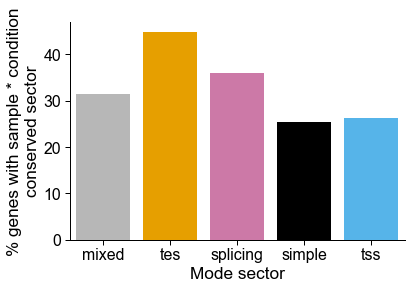

In [67]:
temp12 = pd.DataFrame()
mode_sects = []
percs = []
perc_2 = []
ns = []
n_nums = []
for s in temp.mode_sector.unique().tolist():
    temp2 = temp.loc[temp.mode_sector==s]
    n = len(temp2.gid.unique().tolist())
    n_num = len(temp2.loc[(temp2.same_as_mode==True)&(temp2.perc>=min_perc)].index)
    print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) genes have >={min_perc}% of expressed samples in the same {s} sector as the mode')
    mode_sects.append(s)
    percs.append((n_num/n)*100)
    n_tot = temp.n_tot_genes.values[0]
    perc_2.append((n/n_tot)*100)
    ns.append(n)
    n_nums.append(n_num)
temp12['mode_sector'] = mode_sects
temp12['perc'] = percs
temp12['perc_mode_sect_genes'] = perc_2
temp12['n_genes_w_mode'] = ns
temp12['n_genes_cons_mode'] = n_nums
temp12.head()
c_dict, order = get_sector_colors()
ax = sns.barplot(temp12, 
                 y='perc',
                 x='mode_sector',
                 palette=c_dict,
                 saturation=1)
ylabel = '% genes with sample * condition\nconserved sector'
xlabel = 'Mode sector'
ax.set(ylabel=ylabel, xlabel=xlabel)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


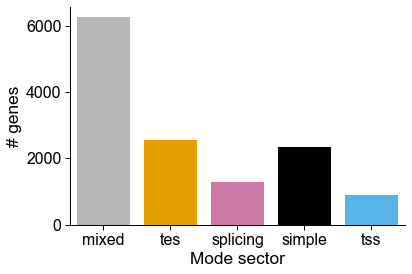

In [68]:
ax = sns.barplot(temp12, 
                 y='n_genes_w_mode',
                 x='mode_sector',
                 palette=c_dict,
                 saturation=1)
ylabel = '# genes'
xlabel = 'Mode sector'
ax.set(ylabel=ylabel, xlabel=xlabel)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


[(0.0, 50.0)]

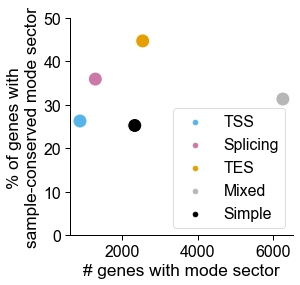

In [69]:
fig, ax = plt.subplots()
fig.set_size_inches(4,4)
ax = sns.scatterplot(temp12, 
                 x='n_genes_w_mode',
                 y='perc',
                 hue='mode_sector',
                 palette=c_dict,
                 hue_order=order,
                 s=200)
xlabel = '# genes with mode sector'
ylabel = '% of genes with\nsample-conserved mode sector'
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend().remove()
legend = ax.legend()
for text in legend.get_texts():
    t = text.get_text()
    if t in ['tss', 'tes']:
        t = t.upper()
    else:
        t = t.capitalize()
    text.set_text(t)
ax.set(ylim=(0,50))
# ax.set(ylim=(-100,7000),
#        xlim=(-100,7000))
# fname = 'figures/genes_per_mode_sector_

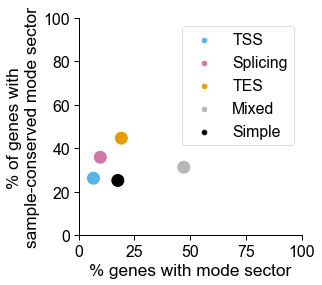

In [70]:
fig, ax = plt.subplots()
fig.set_size_inches(4,4)
ax = sns.scatterplot(temp12, 
                 x='perc_mode_sect_genes',
                 y='perc',
                 hue='mode_sector',
                 palette=c_dict,
                 hue_order=order,
                 s=200)
xlabel = '% genes with mode sector'
ylabel = '% of genes with\nsample-conserved mode sector'
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend().remove()
legend = ax.legend()
for text in legend.get_texts():
    t = text.get_text()
    if t in ['tss', 'tes']:
        t = t.upper()
    else:
        t = t.capitalize()
    text.set_text(t)
ax.set(ylim=(0,100),
       xlim=(0,100))
# ax.set(ylim=(-100,7000),
#        xlim=(-100,7000))
fname = 'figures/mouse_perc_genes_per_mode_sector_cons_scatter.pdf'
plt.savefig(fname, dpi=500)

## What are common mode-2nd mode pairings?

In [31]:
# temp8 = temp[['gid', 'mode_sector_edit', 'mode_sector_edit_2']].drop_duplicates()
# temp8.head()
# temp8.to_csv('sankey_for_sam_2.tsv', sep='\t', index=False)

temp8 = temp[['gid', 'mode_sector', 'mode_sector_2']].drop_duplicates()
temp8.to_csv('mouse_sankey_for_sam_3.tsv', sep='\t', index=False)

In [32]:
temp2 = temp[['gid', 'mode_sector', 'mode_sector_2']].drop_duplicates().groupby(['mode_sector', 'mode_sector_2']).count().reset_index().rename({'gid':'n_genes'}, axis=1)
temp2.sort_values(by='n_genes', ascending=False).head(10)

,mode_sector,mode_sector_2,n_genes
0,mixed,simple,2529
4,simple,mixed,1529
2,mixed,tes,1432
10,tes,mixed,1346
1,mixed,splicing,1311
8,splicing,mixed,1105
11,tes,simple,877
3,mixed,tss,700
14,tss,mixed,502
6,simple,tes,493


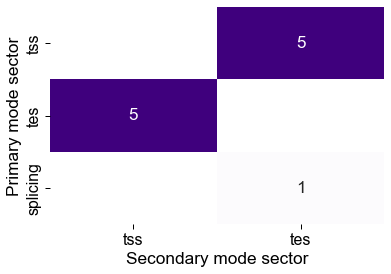

In [33]:
# make a heatmap of these
off_list = ['mixed', 'simple']
temp9 = temp2.loc[~(temp2.mode_sector.isin(off_list))&\
          ~(temp2.mode_sector_2.isin(off_list))]
temp9
temp9 = temp9.pivot(index='mode_sector_2', columns='mode_sector', values='n_genes')
c_dict, order = get_sector_colors(cats=temp9.columns.tolist())
temp9 = temp9[order]
m = dict([(s, i) for i,s in enumerate(order)])
temp9.reset_index(inplace=True)
temp9['thing'] = temp9.mode_sector_2.map(m)
temp9 = temp9.sort_values(by='thing', ascending=True)
temp9.drop('thing', axis=1, inplace=True)
temp9.set_index('mode_sector_2', inplace=True)
ax = sns.heatmap(temp9, cmap='Purples', annot=True, cbar=False)
ax.set(xlabel='Secondary mode sector', 
       ylabel='Primary mode sector')
fname = f'figures/mouse_primary_secondary_mode_corner_heatmap.pdf'
plt.savefig(fname, dpi=500)

In [34]:
# if we consider tss / tes / splicing as "corner"
d = {'mixed':'mixed',
     'splicing': 'corner',
     'tes':'corner',
     'tss':'corner',
     'simple':'simple'}
temp['mode_sector_edit'] = temp.mode_sector.map(d)
temp['mode_sector_edit_2'] = temp.mode_sector_2.map(d)
temp5 = temp.loc[temp.same_as_mode==True]
temp5 = temp5[['gid', 'mode_sector_edit', 'mode_sector_edit_2']].groupby(['mode_sector_edit', 'mode_sector_edit_2']).count().reset_index().rename({'gid':'n_genes'}, axis=1)
temp5.to_csv('mouse_primary_secondary_mode_counts.tsv', sep='\t', index=False)

In [35]:
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso,n_tot_genes,mode_sector_edit,mode_sector_edit_2
0,ENSMUSG00000000028,False,mixed,12,32,37.500000,tss,Cdc45,protein_coding,6.0,13288,mixed,corner
1,ENSMUSG00000000028,True,mixed,20,32,62.500000,tss,Cdc45,protein_coding,6.0,13288,mixed,corner
2,ENSMUSG00000000056,True,mixed,32,32,100.000000,NaN,Narf,protein_coding,6.0,13288,mixed,NaN
3,ENSMUSG00000000058,False,mixed,15,31,48.387097,simple,Cav2,protein_coding,3.0,13288,mixed,simple
4,ENSMUSG00000000058,True,mixed,16,31,51.612903,simple,Cav2,protein_coding,3.0,13288,mixed,simple


In [36]:
temp6 = temp.loc[temp.same_as_mode==True]
temp6.loc[(temp6.mode_sector_edit=='corner')&\
         (temp6.mode_sector_edit_2=='corner')]


,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso,n_tot_genes,mode_sector_edit,mode_sector_edit_2
4881,ENSMUSG00000021549,True,tes,29,32,90.625000,tss,Rasa1,protein_coding,10.0,13288,corner,corner
5266,ENSMUSG00000021986,True,tss,9,21,42.857143,tes,Amer2,protein_coding,14.0,13288,corner,corner
6741,ENSMUSG00000024240,True,tes,13,32,40.625000,tss,Epc1,protein_coding,9.0,13288,corner,corner
8163,ENSMUSG00000026042,True,tes,13,30,43.333333,tss,Col5a2,protein_coding,12.0,13288,corner,corner
13619,ENSMUSG00000032501,True,tss,21,32,65.625000,tes,Trib1,protein_coding,11.0,13288,corner,corner
20457,ENSMUSG00000048482,True,tes,10,28,35.714286,tss,Bdnf,protein_coding,22.0,13288,corner,corner
21880,ENSMUSG00000054733,True,tes,14,32,43.750000,tss,Msra,protein_coding,8.0,13288,corner,corner
22288,ENSMUSG00000056919,True,tss,8,27,29.629630,tes,Cep162,protein_coding,5.0,13288,corner,corner
22833,ENSMUSG00000060002,True,tes,29,32,90.625000,splicing,Chpt1,protein_coding,20.0,13288,corner,corner
24538,ENSMUSG00000074001,True,tss,17,26,65.384615,tes,Klhl40,protein_coding,9.0,13288,corner,corner


In [37]:
temp5
temp5['total'] = temp5.n_genes.sum()
temp5['perc'] = (temp5.n_genes/temp5.total)*100
temp5

,mode_sector_edit,mode_sector_edit_2,n_genes,total,perc
0,corner,corner,11,12541,0.087712
1,corner,mixed,2953,12541,23.546767
2,corner,simple,1311,12541,10.453712
3,mixed,corner,3443,12541,27.453951
4,mixed,simple,2529,12541,20.165856
5,simple,corner,765,12541,6.099992
6,simple,mixed,1529,12541,12.192010


In [38]:
temp.loc[(temp.mode_sector=='tes')&\
         (temp.mode_sector_2=='tss')]

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso,n_tot_genes,mode_sector_edit,mode_sector_edit_2
4880,ENSMUSG00000021549,False,tes,3,32,9.375000,tss,Rasa1,protein_coding,10.0,13288,corner,corner
4881,ENSMUSG00000021549,True,tes,29,32,90.625000,tss,Rasa1,protein_coding,10.0,13288,corner,corner
6740,ENSMUSG00000024240,False,tes,19,32,59.375000,tss,Epc1,protein_coding,9.0,13288,corner,corner
6741,ENSMUSG00000024240,True,tes,13,32,40.625000,tss,Epc1,protein_coding,9.0,13288,corner,corner
8162,ENSMUSG00000026042,False,tes,17,30,56.666667,tss,Col5a2,protein_coding,12.0,13288,corner,corner
8163,ENSMUSG00000026042,True,tes,13,30,43.333333,tss,Col5a2,protein_coding,12.0,13288,corner,corner
20456,ENSMUSG00000048482,False,tes,18,28,64.285714,tss,Bdnf,protein_coding,22.0,13288,corner,corner
20457,ENSMUSG00000048482,True,tes,10,28,35.714286,tss,Bdnf,protein_coding,22.0,13288,corner,corner
21879,ENSMUSG00000054733,False,tes,18,32,56.250000,tss,Msra,protein_coding,8.0,13288,corner,corner
21880,ENSMUSG00000054733,True,tes,14,32,43.750000,tss,Msra,protein_coding,8.0,13288,corner,corner


## Plot a few examples

In [39]:
# first save
temp.to_csv('mouse_sample_sector_mode_cons.tsv', sep='\t', index=False)

In [36]:
temp = pd.read_csv('mouse_sample_sector_mode_cons.tsv', sep='\t')

In [37]:
ca = cerberus.read(cerberus_h5)

In [38]:
temp = temp.loc[(temp.same_as_mode==True)&(temp.perc>=80)]

In [39]:
temp.to_csv('mouse_temp_sample_sector_mode_cons.tsv', sep='\t')

In [29]:
ca = cerberus.read(cerberus_h5)

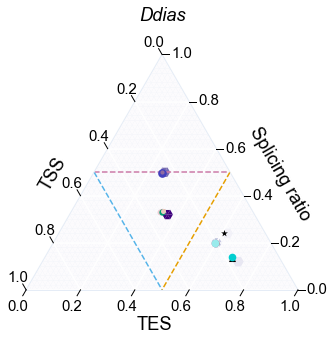

In [31]:
gene = 'Ddias'
plot_sample_det_density_simplex(ca, gene, species='mouse')

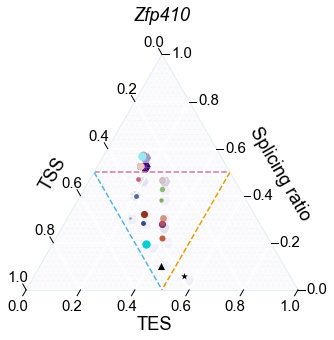

In [30]:
gene = 'Zfp410'
plot_sample_det_density_simplex(ca, gene, species='mouse')

In [39]:
# ca.triplets.loc[(ca.triplets.gname=='Rasa1')&(ca.triplets.source=='sample_det')]

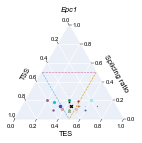

In [76]:
gene = 'Epc1'
plot_obs_mouse_simplex_with_centroid(cerberus_h5,
                  gene,
                  'figures/', 
                  source='sample_det',
                  gene_subset=gene_subset,
                  ver=ver)

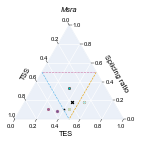

In [75]:
gene = 'Msra'
plot_obs_mouse_simplex_with_centroid(cerberus_h5,
                  gene,
                  'figures/', 
                  source='sample_det',
                  gene_subset=gene_subset,
                  ver=ver)

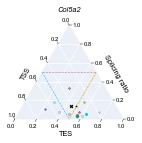

In [40]:
gene = 'Col5a2'
plot_obs_mouse_simplex_with_centroid(cerberus_h5,
                  gene,
                  'figures/', 
                  source='sample_det',
                  gene_subset=gene_subset,
                  ver=ver)

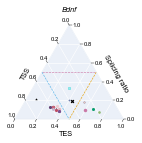

In [37]:
gene = 'Bdnf'
plot_obs_mouse_simplex_with_centroid(cerberus_h5,
                  gene,
                  'figures/', 
                  source='sample_det',
                  gene_subset=gene_subset,
                  ver=ver)

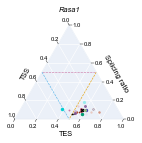

In [38]:
gene = 'Rasa1'
plot_obs_mouse_simplex_with_centroid(cerberus_h5,
                  gene,
                  'figures/', 
                  source='sample_det',
                  gene_subset=gene_subset,
                  ver=ver)

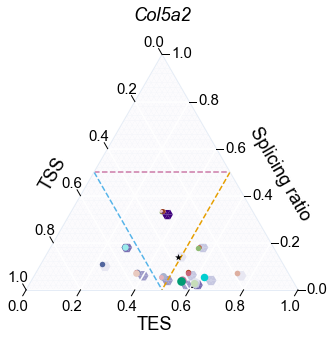

In [118]:
gene = 'Col5a2'
plot_sample_det_density_simplex(ca, gene, species='mouse')

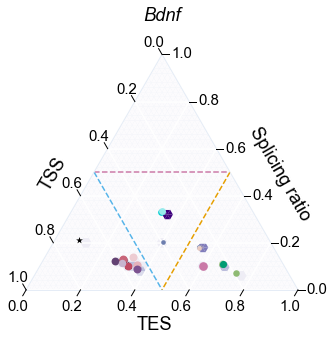

In [119]:
gene = 'Bdnf'
plot_sample_det_density_simplex(ca, gene, species='mouse')

In [120]:
temp.loc[temp.gname=='Bdnf']

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso,mode_sector_edit,mode_sector_edit_2
20456,ENSMUSG00000048482,False,tes,18,28,64.285714,tss,Bdnf,protein_coding,22.0,corner,corner
20457,ENSMUSG00000048482,True,tes,10,28,35.714286,tss,Bdnf,protein_coding,22.0,corner,corner


In [33]:
temp.loc[temp.gname == 'Bdnf']

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso,n_tot_genes
20456,ENSMUSG00000048482,False,tes,18,28,64.285714,tss,Bdnf,protein_coding,22.0,13288
20457,ENSMUSG00000048482,True,tes,10,28,35.714286,tss,Bdnf,protein_coding,22.0,13288


In [123]:
ca.triplets.loc[(ca.triplets.gname=='Bdnf')&\
                (ca.triplets.sector=='tss')&\
                (ca.triplets.source=='sample_det')]
n_num = len(ca.triplets.loc[(ca.triplets.gname=='Bdnf')&\
                (ca.triplets.sector=='tss')&\
                (ca.triplets.source=='sample_det')].index)
n = len(ca.triplets.loc[(ca.triplets.gname=='Bdnf')&\
                (ca.triplets.source=='sample_det')].index)
print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) expressed samples have sect == tss')

32.14% (9/28) expressed samples have sect == tss


In [125]:
ca.triplets.loc[(ca.triplets.gname=='Bdnf')&\
                (ca.triplets.sector=='tes')&\
                (ca.triplets.source=='sample_det')]
n_num = len(ca.triplets.loc[(ca.triplets.gname=='Bdnf')&\
                (ca.triplets.sector=='tes')&\
                (ca.triplets.source=='sample_det')].index)
n = len(ca.triplets.loc[(ca.triplets.gname=='Bdnf')&\
                (ca.triplets.source=='sample_det')].index)
print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) expressed samples have sect == tes')

35.71% (10/28) expressed samples have sect == tes


In [122]:
ca.triplets.loc[(ca.triplets.gname=='Bdnf')&\
                (ca.triplets.sector=='tes')&\
                (ca.triplets.source=='sample_det')]


,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm
85371,sample_det,ENSMUSG00000048482,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,tes,Bdnf,adrenal_4d,0.987589
129000,sample_det,ENSMUSG00000048482,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,tes,Bdnf,adrenal_25d,0.581241
159185,sample_det,ENSMUSG00000048482,1.0,3.0,1.0,3.0,0.500000,0.222222,0.666667,0.111111,tes,Bdnf,heart_18-20mo,7.360303
184933,sample_det,ENSMUSG00000048482,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,tes,Bdnf,gastroc_2mo,1.226732
212839,sample_det,ENSMUSG00000048482,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,tes,Bdnf,gastroc_10d,0.786086
237515,sample_det,ENSMUSG00000048482,2.0,4.0,2.0,6.0,0.666667,0.300000,0.600000,0.100000,tes,Bdnf,c2c12_myoblast,97.072723
338933,sample_det,ENSMUSG00000048482,1.0,3.0,1.0,3.0,0.500000,0.222222,0.666667,0.111111,tes,Bdnf,heart_14d,4.407873
368675,sample_det,ENSMUSG00000048482,1.0,4.0,1.0,4.0,0.400000,0.185185,0.740741,0.074074,tes,Bdnf,heart_2mo,5.930146
412432,sample_det,ENSMUSG00000048482,1.0,3.0,1.0,3.0,0.500000,0.222222,0.666667,0.111111,tes,Bdnf,c2c12_myotube,12.914301
426262,sample_det,ENSMUSG00000048482,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,tes,Bdnf,adrenal_10d,1.009109


## Find a nice lookin gene w/ sample conserved behavior

In [131]:
temp10 = temp.loc[(temp.same_as_mode==True)&\
         (temp.perc>=80)&\
         (temp.max_n_iso > 10)&\
         (temp.mode_sector!='mixed')&\
         (temp.mode_sector!='simple')]
temp10.to_csv('temp_mouse_sample_cons_genes.tsv', sep='\t')

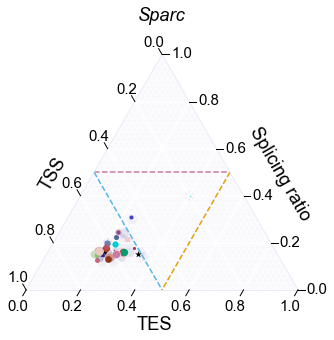

In [132]:
gene = 'Sparc'
plot_sample_det_density_simplex(ca, gene, species='mouse')

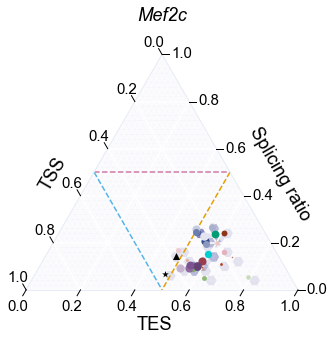

In [133]:
gene = 'Mef2c'
plot_sample_det_density_simplex(ca, gene, species='mouse')

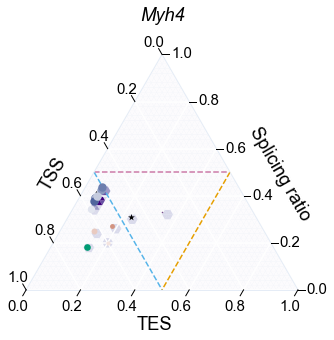

In [134]:
gene = 'Myh4'
plot_sample_det_density_simplex(ca, gene, species='mouse')